# Navigation Project

This notebooks is designed to showcase a Deep Reinforcement Learning agent that learns how to solve 
a g navigation challenge in a given Unity Machine Learning environment. The environment consists of a
rectangular play area in which yellow and blue bananas randomly spawn. If the agent touches a yellow banana,
he receives a reward of +1. If he touches a blue banana he receives a reward of -1. The agent can choose among four possible actions
at each step: 
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has 37 dimensions and contains the agent's velocity as well as a ray-based perception of nearby objects.

### 1. Load packages
We begin by importing necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import platform
from agents import Agent

Cuda version 8.0 detected. Enabling GPU support.


### 2. Environment setup
Next we load up the Unity environment. The required binaries for Windows and Mac are included and
should automatically be selected depending on the detected OS.

In [2]:
# determine OS 
platform = platform.system()

if platform == "Darwin":
    env_path = "Banana_Mac/Banana.app"
elif platform == "Windows":
    env_path = "Banana_Windows_x86_64/Banana.exe"
else:
    print("Unknown OS. Falling back to Mac environment binaries.")
    env_path = "Banana_Mac/Banana.app"

# load the environment
env = UnityEnvironment(file_name=env_path)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# dimension of action space
action_size = brain.vector_action_space_size

# dimension of state space
state = env_info.vector_observations[0]
state_size = len(state)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Training
<span style="color:red">**Running this cell will start a new training session that might overwrite any saved model!**</span>

This notebook cell can be omitted since the folder `checkpoints` already contains a trained model. 
If a GPU is detected by PyTorch, the training process will use it automatically. Otherwise the training will run on the CPU.

Episode 100	Average Score: 1.06
Episode 200	Average Score: 4.79
Episode 300	Average Score: 7.85
Episode 400	Average Score: 9.95
Episode 476	Average Score: 13.03
Environment solved in 376 episodes!	Average Score: 13.03


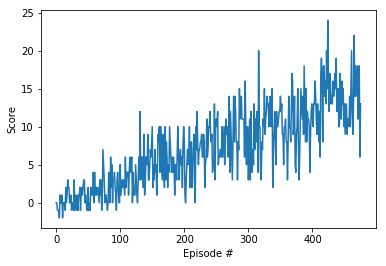

In [3]:
def train_dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] 
        score = 0
        for t in range(max_t):
            
            action = int(agent.act(state, eps))            # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            
            score += reward                                # update the score
            state = next_state             
            
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoints/checkpoint.pth')
            break
    return scores

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

scores = train_dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig("scores.png")
plt.show()

### 4. Observe a trained agent
This creates a new agent and loads a pretrained configuration. 
The agent is then placed in the Unity environment and should start to collect yellow bananas until
it reaches a certain score. The final score is printed upon completion.

In [6]:
# create a new agent and load a trained model state
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('checkpoints/checkpoint.pth'))

# prepare environment for observation
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = int(agent.act(state, 0))              # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    print("Score: {}".format(score), end = '\r')
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 17.0


When finished, the environment can be closed.

In [7]:
env.close()